In [5]:
# lib
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import metrics

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB




# 4.0 Modeling 

In [6]:
# preparing the df 
model_df = pd.read_csv('clean_for_model.csv')

In [7]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57333 entries, 0 to 57332
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   num_label      57333 non-null  int64 
 1   clean_content  57333 non-null  object
dtypes: int64(1), object(1)
memory usage: 896.0+ KB


In [8]:
model_df['num_label'].value_counts()

1    34414
0    22919
Name: num_label, dtype: int64

In [9]:
# going to balance the class using random sample

# Separate the classes
majority_class = model_df[model_df['num_label'] == 1]
minority_class = model_df[model_df['num_label'] == 0]

# Randomly sample from the majority class to match the number of samples in the minority class
majority_undersampled = majority_class.sample(len(minority_class))

# Combine the undersampled majority class samples with the minority class samples
balanced_df = pd.concat([majority_undersampled, minority_class], axis=0)

# Shuffle the rows to mix the classes
balanced_model_df = balanced_df.sample(frac=1).reset_index(drop=True)

In [10]:
balanced_model_df['num_label'].value_counts()

0    22919
1    22919
Name: num_label, dtype: int64

In [11]:
X = balanced_model_df['clean_content']
y = balanced_model_df['num_label']

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                 test_size=0.35,
                                                 random_state=42,
                                                 stratify=y) 

### 4.1.0 Finding the Best Mode to used CountVectorizer (cvec)

Going to use the model below without any tuning, to find out the baseline score for each model below.

In [13]:
# Define Models 
models ={
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'LinearSVC': LinearSVC(max_iter=3000, dual=False),
    'RidgeClassifier': RidgeClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'svc': SVC(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'MultinomialNB':MultinomialNB(),
    'Random Forest': RandomForestClassifier()
}


# Evaluate each model
for name, model in models.items():
    
    # create a pipline for each model 
    pipeline = Pipeline([
        ('cvec', CountVectorizer()),
        ('classifier', model)
    ])
    
    # Fit and score the model
    pipeline.fit(X_train, y_train)  
    train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_val, y_val)  
    
    print(f"{name} Train score: {train_score:.3f} Test score: {test_score:.3f}")

LogisticRegression Train score: 0.888 Test score: 0.783
LinearSVC Train score: 0.930 Test score: 0.770
RidgeClassifier Train score: 0.915 Test score: 0.766
DecisionTreeClassifier Train score: 0.998 Test score: 0.727
KNeighborsClassifier Train score: 0.812 Test score: 0.706
svc Train score: 0.928 Test score: 0.783
AdaBoostClassifier Train score: 0.704 Test score: 0.698
MultinomialNB Train score: 0.835 Test score: 0.779
Random Forest Train score: 0.998 Test score: 0.784


#### 4.1.1 Conclusion from baseline model using cvec 

From the results above, it shows that some models were performs better as compare to the others, So I am going to choose the following model to perform grid search

**MultinomialNB** has the closest range in of train and test score as compare to the rest of the model. So this model has been choosen for grid search.   

**LogisticRegression** The range difference between the train and test score was about 0.11. Althought it is much wider as compare to MultinomialNB, but will still choose this model to perform grid search, due to it perform much more better as compare to the rest of the model. 

**RidgeClassifier**  Will use this model, since this model able to give me the list of top 20 best correlated features.  

**Random Forest** Although it perform badly wihtout any tuning, but will use this model for gridsearch, since this model are able to handle overfitting. 

### 4.2.0 CountVectorizer Top 20 Occurings Words  

Getting the top 20 words using cvec and compare to the models below. To see whether are there any similar words between cvec and the models used below.. 

Text(0, 0.5, 'Words')

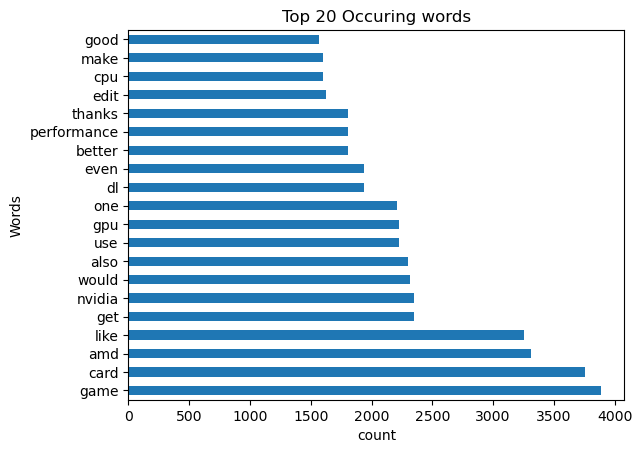

In [16]:
# Initialize and fit the cvec
cvec = CountVectorizer()
X_train_cvec = cvec.fit_transform(X_train)

X_train_df = pd.DataFrame(X_train_cvec.todense(),
                         columns=cvec.get_feature_names_out())

ax = X_train_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
ax.set_title('Top 20 Occuring words')
ax.set_xlabel('count')
ax.set_ylabel('Words')


### 4.3.0 Selected model using cvec for GridSearch

#### 4.3.1.0 MultinomialNB using cvec

In [13]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('classifier', MultinomialNB())
])

pipe_params = {
    'cvec__max_features': [7000], # 3000, 4000, 5000, 6000, 7000
    'cvec__min_df': [5],  # 5, 10, 15
    'cvec__max_df': [.75],  # .75, .80, .85, .90
    'cvec__ngram_range': [(1,2)],  # (1,2), (1,1), (2,2)
    'classifier__alpha': [1.0]  # 0.01, 0.1, 1.0, 10.0
}

gs_nb_cvec = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5, verbose=1, n_jobs=7)

gs_nb_cvec.fit(X_train, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('classifier', MultinomialNB())]),
             n_jobs=7,
             param_grid={'classifier__alpha': [0.01, 0.1, 1.0, 10.0],
                         'cvec__max_df': [0.75, 0.8, 0.85, 0.9],
                         'cvec__max_features': [3000, 4000, 5000, 6000, 7000],
                         'cvec__min_df': [5, 10, 15],
                         'cvec__ngram_range': [(1, 2), (1, 1), (2, 2)]},
             verbose=1)

In [14]:
gs_nb_cvec.best_params_

{'classifier__alpha': 1.0,
 'cvec__max_df': 0.75,
 'cvec__max_features': 7000,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 2)}

In [15]:
print(f"MultinomialNB cvec train accuracy score {round(gs_nb_cvec.score(X_train, y_train),3)}")

print(f"MultinomialNB cvec test accuracy score {round(gs_nb_cvec.score(X_val, y_val),3)}")

MultinomialNB cvec train accuracy score 0.811
MultinomialNB cvec test accuracy score 0.784


#### 4.3.1.1 MultinomialNB cvec Classification Report

In [15]:
# y_pred value using NB cvec
y_pred_nb_cvec = gs_nb_cvec.predict(X_val)

print(confusion_matrix(y_val,y_pred_nb_cvec))
print(classification_report(y_val,y_pred_nb_cvec))

[[6102 2195]
 [1441 6855]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.77      8297
           1       0.76      0.83      0.79      8296

    accuracy                           0.78     16593
   macro avg       0.78      0.78      0.78     16593
weighted avg       0.78      0.78      0.78     16593



#### 4.3.2.0 LogisticRegression using cvec

In [16]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(max_iter=5000))
])

param_grid = [
    {
        'cvec__max_features': [20000],# 5000, 10000, 15000, 18000, 20000
        'cvec__min_df': [2],# 2, 3, 5
        'cvec__max_df': [0.75],# 0.75, 0.85, 0.90, 0.95
        'cvec__ngram_range': [(1,2)],# (1,1), (1,2), (2,2) 
        'lr__C': [0.1],# 0.01, 0.1, 1, 10
        'lr__penalty': ['l2'], # 'l1', 'l2'
        'lr__solver': ['liblinear'],
        'lr__class_weight': [None] # None, 'balanced'
    }]

gs_lr_cvec = GridSearchCV(pipe, 
                  param_grid=param_grid, 
                  cv=3, verbose=2, n_jobs=6)

gs_lr_cvec.fit(X_train, y_train)

Fitting 3 folds for each of 2880 candidates, totalling 8640 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr',
                                        LogisticRegression(max_iter=5000))]),
             n_jobs=6,
             param_grid=[{'cvec__max_df': [0.75, 0.85, 0.9, 0.95],
                          'cvec__max_features': [5000, 10000, 15000, 18000,
                                                 20000],
                          'cvec__min_df': [2, 3, 5],
                          'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                          'lr__C': [0.01, 0.1, 1, 10],
                          'lr__class_weight': [None, 'balanced'],
                          'lr__penalty': ['l1', 'l2'],
                          'lr__solver': ['liblinear']}],
             verbose=2)

In [17]:
gs_lr_cvec.best_params_

{'cvec__max_df': 0.75,
 'cvec__max_features': 20000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'lr__C': 0.1,
 'lr__class_weight': None,
 'lr__penalty': 'l2',
 'lr__solver': 'liblinear'}

In [18]:
print(f" LogisticRegression cvec train accuracy score {round(gs_lr_cvec.score(X_train, y_train),3)}")
print(f" LogisticRegression cvec test accuracy score {round(gs_lr_cvec.score(X_val, y_val),3)}")

 LogisticRegression cvec train accuracy score 0.859
 LogisticRegression cvec test accuracy score 0.792


#### 4.3.2.1  LogisticRegression cvec Classification Report

In [19]:
# y_pred value using logistic regression cvec
y_pred_lr_cvec = gs_lr_cvec.predict(X_val)

print(confusion_matrix(y_val,y_pred_lr_cvec))
print(classification_report(y_val,y_pred_lr_cvec))

[[6495 1802]
 [1647 6649]]
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      8297
           1       0.79      0.80      0.79      8296

    accuracy                           0.79     16593
   macro avg       0.79      0.79      0.79     16593
weighted avg       0.79      0.79      0.79     16593



#### 4.3.2.2  LogisticRegression cvec Top 20 Features 

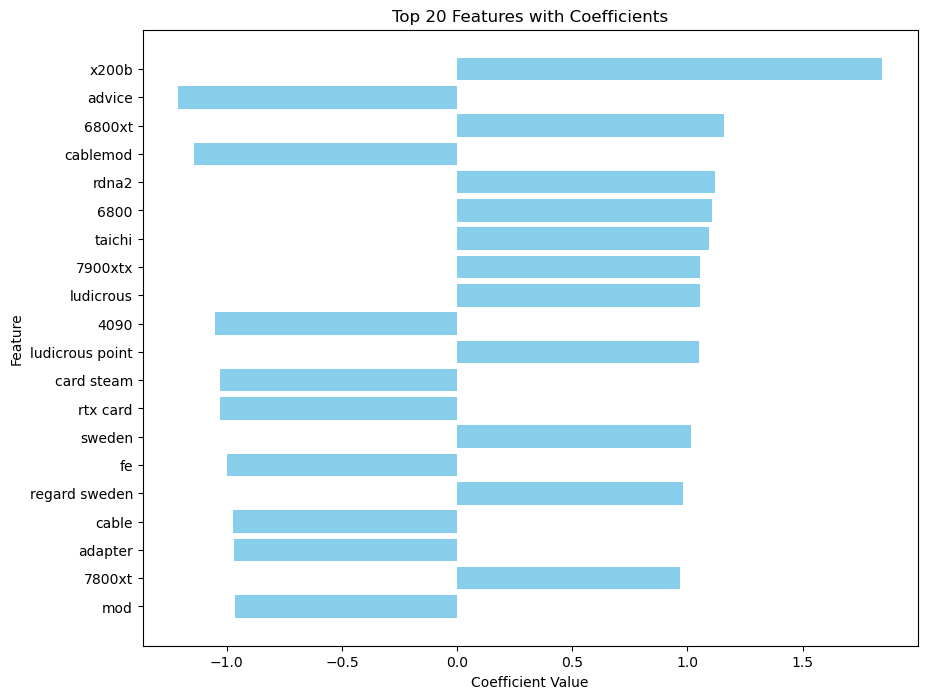

In [20]:
best_model = gs_lr_cvec.best_estimator_

# Extract coefficient and features names
coefficients = best_model.named_steps['lr'].coef_[0]
feature_names = best_model.named_steps['cvec'].get_feature_names_out()

# Match coefficients to feature names and sort by magnitude
features_with_coefficients = sorted(list(zip(feature_names, coefficients)), key=lambda x: abs(x[1]), reverse=True)

# Display top 20 features

# Extract features and coefficients for top 20
top_features = [x[0] for x in features_with_coefficients[:20]]
top_coefs = [x[1] for x in features_with_coefficients[:20]]

# Plot
plt.figure(figsize=(10, 8))
plt.barh(top_features, top_coefs, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 20 Features with Coefficients')
plt.gca().invert_yaxis()  # To display the feature with the highest coefficient at the top
plt.show()



#### 4.3.2.3  LogisticRegression cvec Top 20 Features

Comparing the "Top 20 best coefficient words" with "4.2.0 CountVectorizer Top 20 occurings words", the only common word that could be found between that two list was "4090". 

With this we are able to conclude, the top 20 occuring words using Cvec might not necessarily be the most imformative for predicting the target variable. 

#### 4.3.3.0 RidgeClassifier using cvec

In [22]:
# Now, you can use the original X_train_vec_ct in your pipeline:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rc', RidgeClassifier())
])

param_grid = [
    {
        'cvec__max_features': [20000],# 5000, 10000, 15000, 18000, 20000
        'cvec__min_df': [2],# 2, 3, 5
        'cvec__max_df': [0.75],# 0.75, 0.85, 0.90, 0.95
        'cvec__ngram_range': [(1,2)], # (1,1), (1,2), (2,2) 
        'rc__alpha': [10],# 0.01, 0.1, 1, 10, 100
     
    }]

gs_rc_cvec = GridSearchCV(pipe, 
                  param_grid=param_grid, 
                  cv=3, verbose=2, n_jobs=6)

gs_rc_cvec.fit(X_train, y_train)

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rc', RidgeClassifier())]),
             n_jobs=6,
             param_grid=[{'cvec__max_df': [0.75, 0.85, 0.9, 0.95],
                          'cvec__max_features': [5000, 10000, 15000, 18000,
                                                 20000],
                          'cvec__min_df': [2, 3, 5],
                          'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                          'rc__alpha': [0.01, 0.1, 1, 10, 100]}],
             verbose=2)

In [23]:
gs_rc_cvec.best_params_

{'cvec__max_df': 0.75,
 'cvec__max_features': 20000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'rc__alpha': 10}

In [25]:
print(f" RidgeClassifier cvec train accuracy score {round(gs_rc_cvec.score(X_train, y_train),3)}")
print(f" RidgeClassifier cvec test accuracy score {round(gs_rc_cvec.score(X_val, y_val),3)}")

 RidgeClassifier cvec train accuracy score 0.914
 RidgeClassifier cvec test accuracy score 0.786


#### 4.3.3.1 RidgeClassifier cvec Classification Report

In [26]:
# y_pred value using logistic regression cvec
y_pred_rc_cvec = gs_rc_cvec.predict(X_val)

print(confusion_matrix(y_val,y_pred_rc_cvec))
print(classification_report(y_val,y_pred_rc_cvec))

[[6468 1829]
 [1719 6577]]
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      8297
           1       0.78      0.79      0.79      8296

    accuracy                           0.79     16593
   macro avg       0.79      0.79      0.79     16593
weighted avg       0.79      0.79      0.79     16593



#### 4.3.3.2 RidgeClassifier cvec Top 20 Features

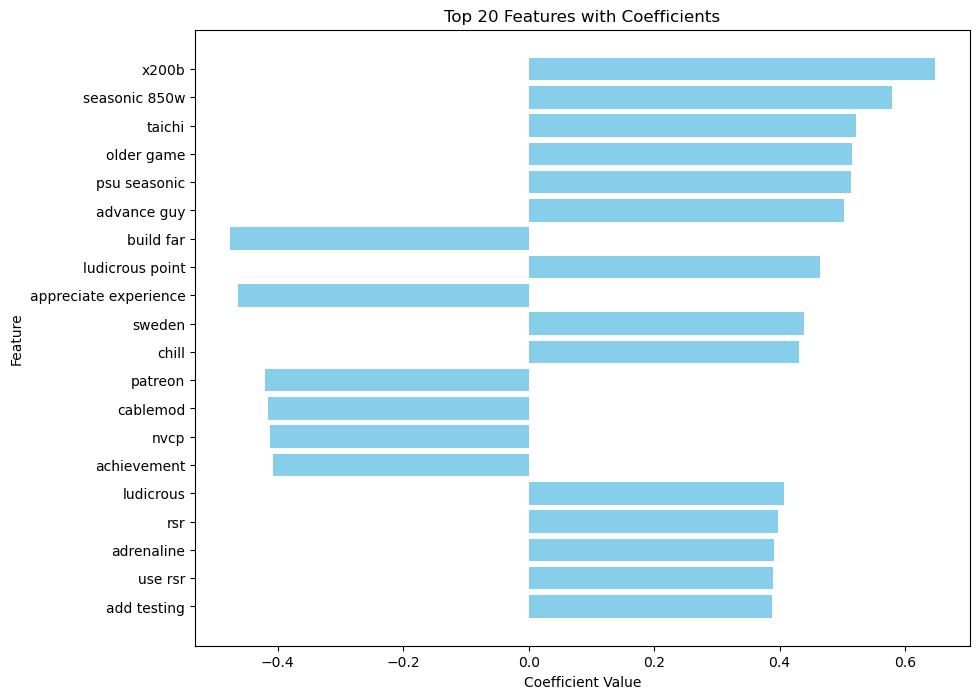

In [27]:
best_model = gs_rc_cvec.best_estimator_

# Extract coefficient and features names
coefficients = best_model.named_steps['rc'].coef_[0]
feature_names = best_model.named_steps['cvec'].get_feature_names_out()

# Match coefficients to feature names and sort by magnitude
features_with_coefficients = sorted(list(zip(feature_names, coefficients)), key=lambda x: abs(x[1]), reverse=True)

# Display top 20 features

# Extract features and coefficients for top 20
top_features = [x[0] for x in features_with_coefficients[:20]]
top_coefs = [x[1] for x in features_with_coefficients[:20]]

# Plot
plt.figure(figsize=(10, 8))
plt.barh(top_features, top_coefs, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 20 Features with Coefficients')
plt.gca().invert_yaxis()  # To display the feature with the highest coefficient at the top
plt.show()

#### 4.3.3.3 RidgeClassifier cvec Top 20 features 

**Comparing to Logistic Regression Top 20 Features**

when we comparing the Ridge Classifier top 20 features with Logistic Regression, we can observe that out of 20 top features, they had 12 features in common. This is expected as the fundamental difference between  Logistic Regression and Ridge Classifier is the regularization term. 

**Comparing to  Top 20 Occurings words using cvec**

The only common word that could be found between that two list was "4090".

With this we are able to conclude, the top 20 occuring words using Cvec might not necessarily be the most imformative for predicting the target variable.

#### 4.3.4.0 Random Forest using cvec 

In [28]:
# Adjust the pipeline:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

# Adjust the hyperparameters for GridSearchCV:
param_grid = [
    {
        'cvec__max_features': [10000], #5000, 10000, 15000
        'cvec__min_df': [5],# 2, 3, 5
        'cvec__max_df': [0.85], # 0.75, 0.85
        'cvec__ngram_range': [(1,2)], #(1,1), (1,2)
        'rf__n_estimators': [200], #100, 150, 200 
        'rf__max_depth': [None], #None, 10, 20, 30
        'rf__min_samples_split': [4], #2, 4, 6
        'rf__min_samples_leaf': [1], #1, 2, 3
        'rf__max_features': ['sqrt'] # None, 'sqrt'
    }
]

gs_rf_cvec = GridSearchCV(pipe, 
                     param_grid=param_grid, 
                     cv=3, verbose=1, n_jobs=-1)

gs_rf_cvec.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'cvec__max_df': [0.85], 'cvec__max_features': [10000],
                          'cvec__min_df': [5], 'cvec__ngram_range': [(1, 2)],
                          'rf__max_depth': [None], 'rf__max_features': ['sqrt'],
                          'rf__min_samples_leaf': [1],
                          'rf__min_samples_split': [4],
                          'rf__n_estimators': [200]}],
             verbose=1)

In [29]:
gs_rf_cvec.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': 10000,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 2),
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 4,
 'rf__n_estimators': 200}

In [31]:
print(f" Random Forest cvec train accuracy score {round(gs_rf_cvec.score(X_train, y_train),3)}")
print(f" Random Forest cvec test accuracy score {round(gs_rf_cvec.score(X_val, y_val),3)}")

 Random Forest cvec train accuracy score 0.995
 Random Forest cvec test accuracy score 0.788


#### 4.3.4.1 Random Forest cvec Classification Report

In [32]:
y_pred_rf_cvec = gs_rf_cvec.predict(X_val)

print(confusion_matrix(y_val,y_pred_rf_cvec))
print(classification_report(y_val,y_pred_rf_cvec))

[[6480 1817]
 [1708 6588]]
              precision    recall  f1-score   support

           0       0.79      0.78      0.79      8297
           1       0.78      0.79      0.79      8296

    accuracy                           0.79     16593
   macro avg       0.79      0.79      0.79     16593
weighted avg       0.79      0.79      0.79     16593



#### 4.3.4.2 Random Forest cvec Top 20 Features

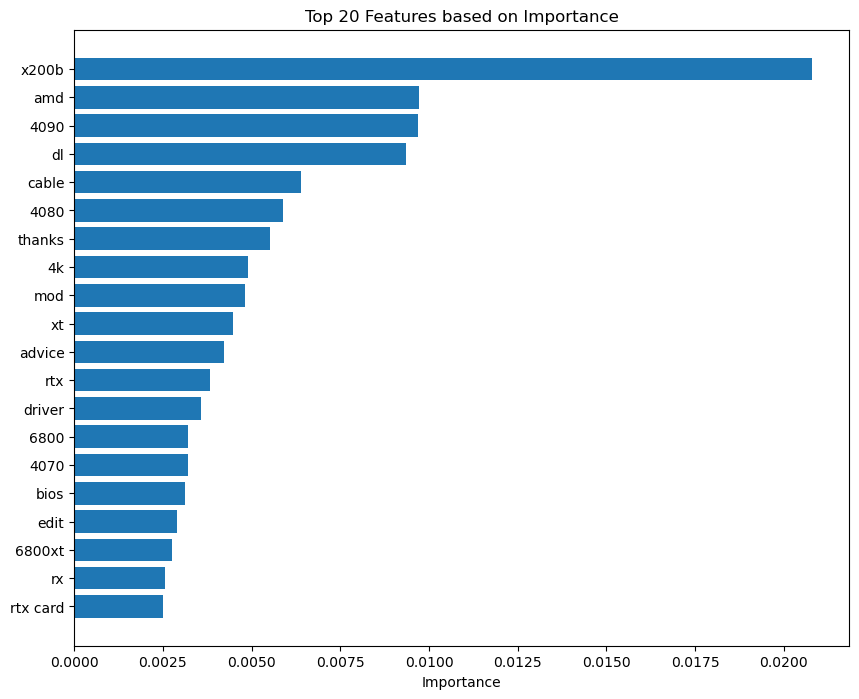

In [33]:
# Extract the best RandomForest model and the CountVectorizer from the GridSearchCV results
best_rf_model = gs_rf_cvec.best_estimator_.named_steps['rf']
feature_names = gs_rf_cvec.best_estimator_.named_steps['cvec'].get_feature_names_out()

# Get the feature importances and sort them
feature_importances = best_rf_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

# Display top N features using a horizontal bar chart
def plot_top_features(N=20):
    top_features = [feature_names[i] for i in sorted_indices[:N]]
    top_importances = [feature_importances[i] for i in sorted_indices[:N]]
    
    plt.figure(figsize=(10, 8))
    plt.barh(top_features[::-1], top_importances[::-1], align='center')
    plt.xlabel('Importance')
    plt.title(f'Top {N} Features based on Importance')
    plt.show()

# Call the function to display the chart for top 20 features
plot_top_features(N=20)

#### 4.3.4.2 Random Forest cvec Top 20 features

**Comparing to Logistic Regression and Ridge Classifier Top 20 Features**
we can observe that out of 20 top features, they had 10 features in common. So we can conclude that random forest seem to have some features that is important to random forest and it is important to the other model as well. 

**Comparing to Top 20 Occurings words using cvec** 

The only common words that could be found between that two list was "4090" and 'driver'.

With this we are able to conclude, the top 20 occuring words using Cvec might not necessarily be the most imformative for predicting the target variable. 

### 4.4.0 Modeling using TfidfVectorizer (tvec)

Going to use the model below without any tuning, to find out the baseline score for each model. 

In [34]:
# Define Models 
models ={
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'LinearSVC': LinearSVC(max_iter=3000, dual=False),
    'RidgeClassifier': RidgeClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'svc': SVC(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'MultinomialNB':MultinomialNB(),
    'Random Forest': RandomForestClassifier()
}


# Evaluate each model
for name, model in models.items():
    
    # create a pipline for each model 
    pipeline = Pipeline([
        ('tvec',  TfidfVectorizer()),
        ('classifier', model)
    ])
    
    # Fit and score the model
    pipeline.fit(X_train, y_train)
    train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_val, y_val) 
    
    print(f"{name} Train score: {train_score:.3f} Test score: {test_score:.3f}")


LogisticRegression Train score: 0.848 Test score: 0.786
LinearSVC Train score: 0.908 Test score: 0.782
RidgeClassifier Train score: 0.894 Test score: 0.784
DecisionTreeClassifier Train score: 0.998 Test score: 0.730
KNeighborsClassifier Train score: 0.852 Test score: 0.750
svc Train score: 0.969 Test score: 0.794
AdaBoostClassifier Train score: 0.713 Test score: 0.705
MultinomialNB Train score: 0.843 Test score: 0.776
Random Forest Train score: 0.998 Test score: 0.787


#### 4.4.1 Conclusion from baseline model using  tvec 

From the results above, it shows that some models were performs better as compare to the others, So I am going to choose the following model to perform grid search

**MultinomialNB** has the closest range in of train and test score as compare to the rest of the model. So this model has been choosen for grid search.   

**LogisticRegression** The range difference between the train and test score was about 0.11. Althought it is much wider as compare to MultinomialNB, but will still choose this model to perform grid search, due to it perform much more better as compare to the rest of the model. 

**RidgeClassifier**  Will use this model, since this model able to give me the list of top 20 best correlated features.  

**Random Forest** Although it perform badly wihtout any tuning, but will use this model for gridsearch, since this model are able to handle overfitting. 

### 4.5.0 CountVectorizer Top 20 Occurings Words  

Getting the top 20 words using tvec and compare to the models below. To see whether are there any similar words between tvec and the models used below.. 

Text(0, 0.5, 'Words')

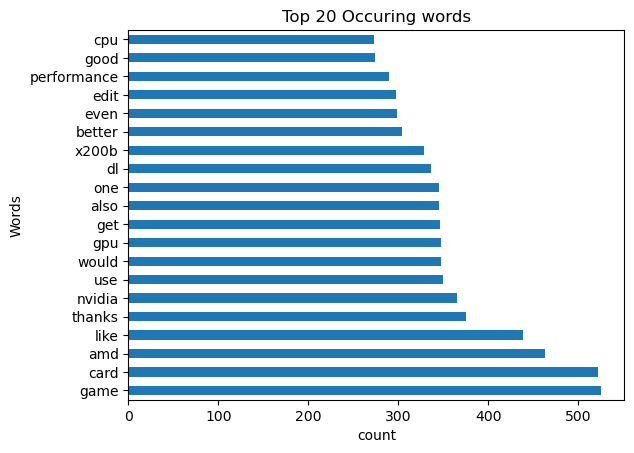

In [17]:
# Initialize and fit the cvec
cvec = TfidfVectorizer()
X_train_cvec = cvec.fit_transform(X_train)

X_train_df = pd.DataFrame(X_train_cvec.todense(),
                         columns=cvec.get_feature_names_out())

ax = X_train_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
ax.set_title('Top 20 Occuring words')
ax.set_xlabel('count')
ax.set_ylabel('Words')

#### 4.6.1.0 MultinomialNB using tvec

In [19]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

pipe_params = {
    'tvec__max_features': [10000], # 4000, 6000, 8000, 10000
    'tvec__min_df': [5],  # 5, 10, 15
    'tvec__max_df': [.75],  # .75, .80, .85, .90
    'tvec__ngram_range': [(1,2)],  # (1,2), (1,1), (2,2)
    'classifier__alpha': [1.0]  # 0.01, 0.1, 1.0, 10.0
}

gs_nb_tvec = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5, verbose=2,  n_jobs=6)

gs_nb_tvec.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('classifier', MultinomialNB())]),
             n_jobs=6,
             param_grid={'classifier__alpha': [1.0], 'tvec__max_df': [0.75],
                         'tvec__max_features': [10000], 'tvec__min_df': [5],
                         'tvec__ngram_range': [(1, 2)]},
             verbose=2)

In [20]:
gs_nb_tvec.best_params_

{'classifier__alpha': 1.0,
 'tvec__max_df': 0.75,
 'tvec__max_features': 10000,
 'tvec__min_df': 5,
 'tvec__ngram_range': (1, 2)}

In [21]:
print(f" MultinomialNB tvec train accuracy score {round(gs_nb_tvec.score(X_train, y_train),3)}")
print(f" MultinomialNB tvec test accuracy score {round(gs_nb_tvec.score(X_val, y_val),3)}")

 MultinomialNB tvec train accuracy score 0.837
 MultinomialNB tvec test accuracy score 0.789


#### 4.6.1.1 MultinomialNB tvec Classification Report

In [22]:
# y_pred value using NB cvec
y_pred_nb_tvec = gs_nb_tvec.predict(X_val)

print(confusion_matrix(y_val,y_pred_nb_tvec))
print(classification_report(y_val,y_pred_nb_tvec))

[[5967 2055]
 [1323 6699]]
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      8022
           1       0.77      0.84      0.80      8022

    accuracy                           0.79     16044
   macro avg       0.79      0.79      0.79     16044
weighted avg       0.79      0.79      0.79     16044



#### 4.6.2.0  LogisticRegression using tvec

In [24]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter=5000))
])

param_grid = [
    {
        'tvec__max_features': [20000],# 5000, 10000, 15000, 18000, 20000
        'tvec__min_df': [2],# 2, 3, 5
        'tvec__max_df': [0.75],# 0.75, 0.85, 0.90, 0.95
        'tvec__ngram_range': [(1,2)],# (1,1), (1,2), (2,2) 
        'lr__C': [1],# 0.01, 0.1, 1, 10
        'lr__penalty': ['l2'], #'l1', 'l2'
        'lr__solver': ['liblinear'],
        'lr__class_weight': [None] # None, 'balanced'
    }]

gs_lr_tvec = GridSearchCV(pipe, 
                  param_grid=param_grid, 
                  cv=3, verbose=2, n_jobs=6)

gs_lr_tvec.fit(X_train, y_train)

Fitting 3 folds for each of 2880 candidates, totalling 8640 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(max_iter=5000))]),
             n_jobs=6,
             param_grid=[{'lr__C': [0.01, 0.1, 1, 10],
                          'lr__class_weight': [None, 'balanced'],
                          'lr__penalty': ['l1', 'l2'],
                          'lr__solver': ['liblinear'],
                          'tvec__max_df': [0.75, 0.85, 0.9, 0.95],
                          'tvec__max_features': [5000, 10000, 15000, 18000,
                                                 20000],
                          'tvec__min_df': [2, 3, 5],
                          'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)]}],
             verbose=2)

In [25]:
gs_lr_tvec.best_params_

{'lr__C': 1,
 'lr__class_weight': None,
 'lr__penalty': 'l2',
 'lr__solver': 'liblinear',
 'tvec__max_df': 0.75,
 'tvec__max_features': 20000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [26]:
print(f" LogisticRegression tvec train accuracy score {round(gs_lr_tvec.score(X_train, y_train),3)}")
print(f" LogisticRegression tvec test accuracy score {round(gs_lr_tvec.score(X_val, y_val),3)}")

 LogisticRegression tvec train accuracy score 0.879
 LogisticRegression tvec test accuracy score 0.798


#### 4.6.2.1 LogisticRegression tvec Classification Report

In [27]:
# y_pred value using NB cvec
y_pred_lr_tvec = gs_lr_tvec.predict(X_val)

print(confusion_matrix(y_val,y_pred_lr_tvec))
print(classification_report(y_val,y_pred_lr_tvec))

[[6246 1776]
 [1458 6564]]
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      8022
           1       0.79      0.82      0.80      8022

    accuracy                           0.80     16044
   macro avg       0.80      0.80      0.80     16044
weighted avg       0.80      0.80      0.80     16044



#### 4.6.2.2  LogisticRegression tvec Top 20 features 

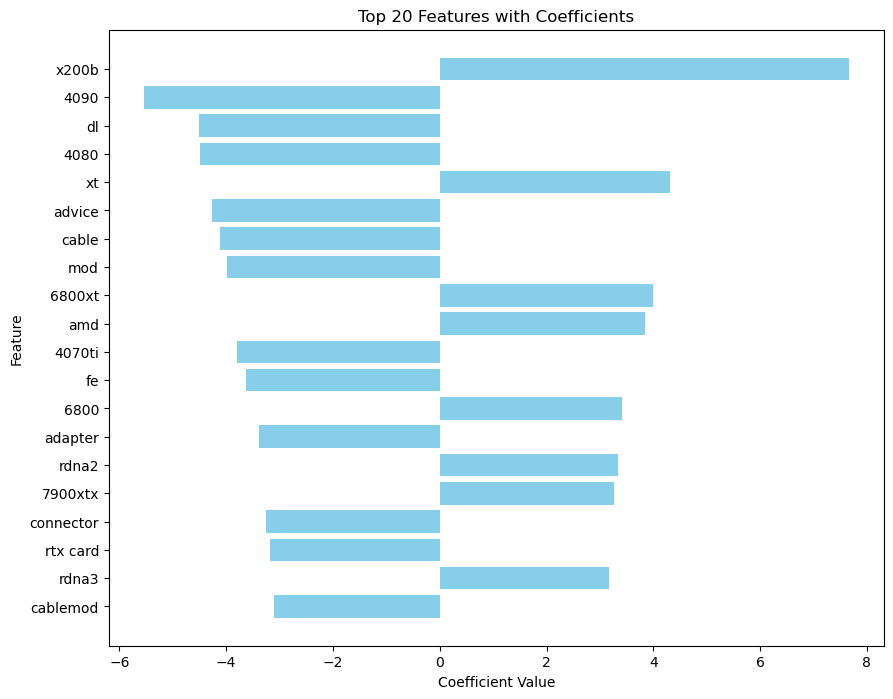

In [28]:
best_model = gs_lr_tvec.best_estimator_

# Extract coefficient and features names
coefficients = best_model.named_steps['lr'].coef_[0]
feature_names = best_model.named_steps['tvec'].get_feature_names_out()

# Match coefficients to feature names and sort by magnitude
features_with_coefficients = sorted(list(zip(feature_names, coefficients)), key=lambda x: abs(x[1]), reverse=True)

# Display top 20 features

# Extract features and coefficients for top 20
top_features = [x[0] for x in features_with_coefficients[:20]]
top_coefs = [x[1] for x in features_with_coefficients[:20]]

# Plot
plt.figure(figsize=(10, 8))
plt.barh(top_features, top_coefs, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 20 Features with Coefficients')
plt.gca().invert_yaxis()  # To display the feature with the highest coefficient at the top
plt.show()

#### 4.6.2.2  LogisticRegression cvec Top 20 Features

Comparing the "Top 20 best coefficient words" with "4.5.0 TfidfVectorizer Top 20 occurings words", the only common word that could be found between that two list was "dl". 

With this we are able to conclude, the top 20 occuring words using tvec might not necessarily be the most imformative for predicting the target variable. 

#### 4.6.3.0  RidgeClassifier using tvec

In [29]:
# Now, you can use the original X_train_vec_ct in your pipeline:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rc', RidgeClassifier())
])

param_grid = [
    {
        'tvec__max_features': [18000],# 5000, 10000, 15000, 18000, 20000
        'tvec__min_df': [2],# 2, 3, 5
        'tvec__max_df': [0.75],# 0.75, 0.85, 0.90, 0.95
        'tvec__ngram_range': [(1,2)],# (1,1), (1,2), (2,2) 
        'rc__alpha': [10],# 0.001, 0.01, 0.1, 1, 10, 100
     
    }]

gs_rc_tvec = GridSearchCV(pipe, 
                  param_grid=param_grid, 
                  cv=3, verbose=2, n_jobs=-1)

gs_rc_tvec.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rc', RidgeClassifier())]),
             n_jobs=-1,
             param_grid=[{'rc__alpha': [10], 'tvec__max_df': [0.75],
                          'tvec__max_features': [18000], 'tvec__min_df': [2],
                          'tvec__ngram_range': [(1, 2)]}],
             verbose=2)

In [30]:
gs_rc_tvec.best_params_

{'rc__alpha': 10,
 'tvec__max_df': 0.75,
 'tvec__max_features': 18000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [31]:
print(f" RidgeClassifier tvec train accuracy score {round(gs_rc_tvec.score(X_train, y_train),3)}")
print(f" RidgeClassifier tvec test accuracy score {round(gs_rc_tvec.score(X_val, y_val),3)}")

 RidgeClassifier tvec train accuracy score 0.855
 RidgeClassifier tvec test accuracy score 0.795


#### 4.6.3.1  RidgeClassifier using tvec Classification Report

In [32]:
# y_pred value using NB cvec
y_pred_rc_tvec = gs_rc_tvec.predict(X_val)

print(confusion_matrix(y_val,y_pred_rc_tvec))
print(classification_report(y_val,y_pred_rc_tvec))

[[6141 1881]
 [1414 6608]]
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      8022
           1       0.78      0.82      0.80      8022

    accuracy                           0.79     16044
   macro avg       0.80      0.79      0.79     16044
weighted avg       0.80      0.79      0.79     16044



#### 4.6.3.2  RidgeClassifier tvec Top 20 Features

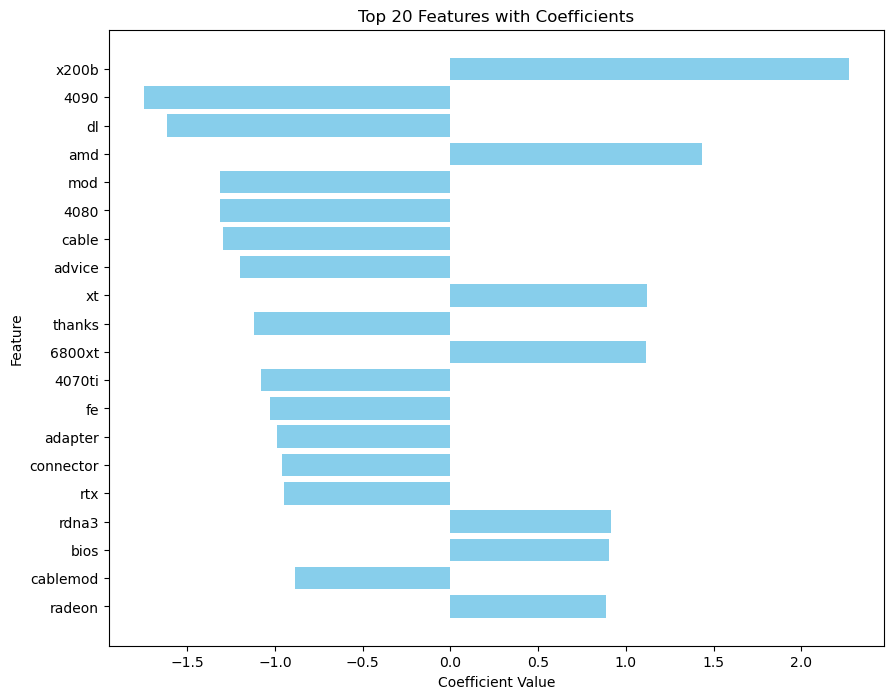

In [33]:
best_model = gs_rc_tvec.best_estimator_

# Extract coefficient and features names
coefficients = best_model.named_steps['rc'].coef_[0]
feature_names = best_model.named_steps['tvec'].get_feature_names_out()

# Match coefficients to feature names and sort by magnitude
features_with_coefficients = sorted(list(zip(feature_names, coefficients)), key=lambda x: abs(x[1]), reverse=True)

# Display top 20 features

# Extract features and coefficients for top 20
top_features = [x[0] for x in features_with_coefficients[:20]]
top_coefs = [x[1] for x in features_with_coefficients[:20]]

# Plot
plt.figure(figsize=(10, 8))
plt.barh(top_features, top_coefs, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 20 Features with Coefficients')
plt.gca().invert_yaxis()  # To display the feature with the highest coefficient at the top
plt.show()

#### 4.6.3.2  RidgeClassifier tvec Top 20 Features

Comparing the "Top 20 best coefficient words" with "4.5.0 TfidfVectorizer Top 20 occurings words", the only common word that could be found between that two list was "dl". 

With this we are able to conclude, the top 20 occuring words using tvec might not necessarily be the most imformative for predicting the target variable. 

#### 4.6.4.0 Random Forest using tvec 

In [38]:
# Adjust the pipeline:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

# Adjust the hyperparameters for GridSearchCV:
param_grid = [
    {
        'tvec__max_features': [15000], #5000, 10000, 15000
        'tvec__min_df': [2],# 2, 3, 5
        'tvec__max_df': [0.85], # 0.75, 0.85, 0.90
        'tvec__ngram_range': [(1,1)], #(1,1), (1,2)
        'rf__n_estimators': [150], #100, 150, 200 
        'rf__max_depth': [None], #None, 10, 20, 30
        'rf__min_samples_split': [4], #2, 4, 6
        'rf__min_samples_leaf': [1], #1, 2, 3
        'rf__max_features': ['sqrt'] # None, 'sqrt'
    }
]

gs_rf_tvec = GridSearchCV(pipe, 
                     param_grid=param_grid, 
                     cv=3, verbose=1, n_jobs=6)

gs_rf_tvec.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=6,
             param_grid=[{'rf__max_depth': [None], 'rf__max_features': ['sqrt'],
                          'rf__min_samples_leaf': [1],
                          'rf__min_samples_split': [4],
                          'rf__n_estimators': [150], 'tvec__max_df': [0.85],
                          'tvec__max_features': [15000], 'tvec__min_df': [2],
                          'tvec__ngram_range': [(1, 1)]}],
             verbose=1)

In [39]:
gs_rf_tvec.best_params_

{'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 4,
 'rf__n_estimators': 150,
 'tvec__max_df': 0.85,
 'tvec__max_features': 15000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1)}

In [40]:
print(f" Random Forest tvec train accuracy score {round(gs_rf_tvec.score(X_train, y_train),3)}")
print(f" Random Forest tvec test accuracy score {round(gs_rf_tvec.score(X_val, y_val),3)}")

 Random Forest tvec train accuracy score 1.0
 Random Forest tvec test accuracy score 0.79


#### 4.6.4.1 Random Forest using tvec Classification Report

In [41]:
# y_pred value using NB cvec
y_pred_rf_tvec = gs_rf_tvec.predict(X_val)

print(confusion_matrix(y_val,y_pred_rf_tvec))
print(classification_report(y_val,y_pred_rf_tvec))

[[6164 1858]
 [1504 6518]]
              precision    recall  f1-score   support

           0       0.80      0.77      0.79      8022
           1       0.78      0.81      0.79      8022

    accuracy                           0.79     16044
   macro avg       0.79      0.79      0.79     16044
weighted avg       0.79      0.79      0.79     16044



#### 4.6.4.2 Random Forest tvec Top 20 Features

In [ ]:
# Extract the best RandomForest model and the CountVectorizer from the GridSearchCV results
best_rf_model = gs_rf_tvec.best_estimator_.named_steps['rf']
feature_names = gs_rf_tvec.best_estimator_.named_steps['tvec'].get_feature_names_out()

# Get the feature importances and sort them
feature_importances = best_rf_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

# Display top N features using a horizontal bar chart
def plot_top_features(N=20):
    top_features = [feature_names[i] for i in sorted_indices[:N]]
    top_importances = [feature_importances[i] for i in sorted_indices[:N]]
    
    plt.figure(figsize=(10, 8))
    plt.barh(top_features[::-1], top_importances[::-1], align='center')
    plt.xlabel('Importance')
    plt.title(f'Top {N} Features based on Importance')
    plt.show()

# Call the function to display the chart for top 20 features
plot_top_features(N=20)

#### 4.6.4.2 Random Forest tvec Top 20 Features

# 5.0 Modelling Conclusions

### 5.1 Model Performance
|Model|Train Score|Test Score|F1-Score|
|---|---|---|---|
|Naive Bayes with cvec|0.811|0.784|0.79|
|Naive Bayes with tvec|0.837|0.789|0.80|
|Random Forest with cvec|0.995|0.788|0.79|
|Random Forest with tvec|1.0|0.790|0.79|
|Logistic Regression with cvec|0.859|0.792|0.79|
|Logistic Regression with tvec|0.879|0.798|0.80|
|RidgeClassifier with cvec|0.914|0.786|0.79|
|RidgeClassifier with tvec|0.855|0.795|0.80|

All of our models perform similarly. However, the one can be further improve on is Naive Bayes CountVectorizer, the train and test score range where not far apart. 
 
The preferred production model is therefore Naive Bayes with CountVectorizer.

This model can be deployed in GPU discussion forums to separate posts about nVidia / AMD for sentiment analysis.

### 5.2 Lesson learn

Using NLTK to preprocess the text would product slightly higher score in terms of accuracy as compared using spaCY.

I had try to keep the model number and model name for all Nvidia graphic cards, In hope that it might helps the model to distinguish between Amd and Nvidia, but it didn't help the model to perform better either. 

I had tried to scrap all the comments from both subreddit amd and nvidia and merge it with the body text of the respective subreddit, after sending it to pre processsing using NLTK or spaCy, it does not improve the model performance. 

what work was instead of merging comments with body text, I used body text and merge with title and pre processing with NLTK, it will be able to produce the best score that I had so far.  


# 6.0 Sentiment Analysis Conclusion 

### Headline Conclusion Using VADER compound score 

1. The mean value of r/nvidia compound score was 0.207 

2. The mean value of r/amd compound score was 0.137 

3. Using the compound score, r/amd generally has a more negative sentiment as compare to r/nvidia

4. Hence, it is likely a genuine issue with AMD product 



# 7.0 Recommendations

## Modelling

1. The Naive Bayes with CountVectorizer.r model has the best result and run time, hence it can be deployed as to GPU discussion forums. 

2. While the F1-score % and accuracy around 79% it is good enough for our case. Our purpose is to roughly estimate whether there is any significantly more negative sentiment surround either AMD or Nvidia. The proportion of false positive and false negatives is decent based on the f1 score 


## Senitment Analysis 

1. Engineering needs to be given more resources to apply towards development for greater driver stability. 

2. A good start would be development and implementation of comprehensive testing suite before any new grpahics release. 


